In [32]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
#import gcsfs
import cftime
import pandas as pd
import xesmf as xe
#import xskillscoere as xs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cartopy as cart

In [2]:
chicago_LAT=41.88
chicago_LON=(360-87.6298)%360
#
cvals = '/Users/hrh/Desktop/TwoMoments21/cvals/cmip6/'

In [3]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat        = ds[get_lat_name(ds)]
    weight     = np.cos(np.deg2rad(lat))
    weight    /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

In [38]:
#q = quantile function
qcmip6_djfpath  = cvals+'cmip6_quantiles_djf.zarr'
qcmip6_mampath  = cvals+'cmip6_quantiles_mam.zarr'
qcmip6_jjapath  = cvals+'cmip6_quantiles_jja.zarr'
qcmip6_sonpath  = cvals+'cmip6_quantiles_son.zarr'

In [39]:
qcmip6_djf = xr.open_zarr(qcmip6_djfpath).tasmax
qcmip6_mam = xr.open_zarr(qcmip6_mampath).tasmax
qcmip6_jja = xr.open_zarr(qcmip6_jjapath).tasmax
qcmip6_son = xr.open_zarr(qcmip6_sonpath).tasmax

In [50]:
qcmip6_djf

<xarray.DataArray 'tasmax' (source_id: 10, experiment_id: 2, quantile: 30,
                            day: 92, lat: 61, lon: 121)>
dask.array<open_dataset-tasmax, shape=(10, 2, 30, 92, 61, 121), dtype=float64, chunksize=(3, 1, 8, 23, 16, 61), chunktype=numpy.ndarray>
Coordinates:
  * day            (day) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * experiment_id  (experiment_id) <U10 'ssp370' 'historical'
  * lat            (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 75 78 81 84 87 90
  * lon            (lon) int64 0 3 6 9 12 15 18 ... 342 345 348 351 354 357 360
  * quantile       (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * source_id      (source_id) <U17 'ACCESS-CM2' ... 'MRI-ESM2-0'

In [41]:
#CHECK
qcmip6_djf_ano      = qcmip6_djf.sel(experiment_id='ssp370') - qcmip6_djf.sel(experiment_id='historical')
qano_djf_std_mean   = qcmip6_djf_ano.std('source_id').mean('day')

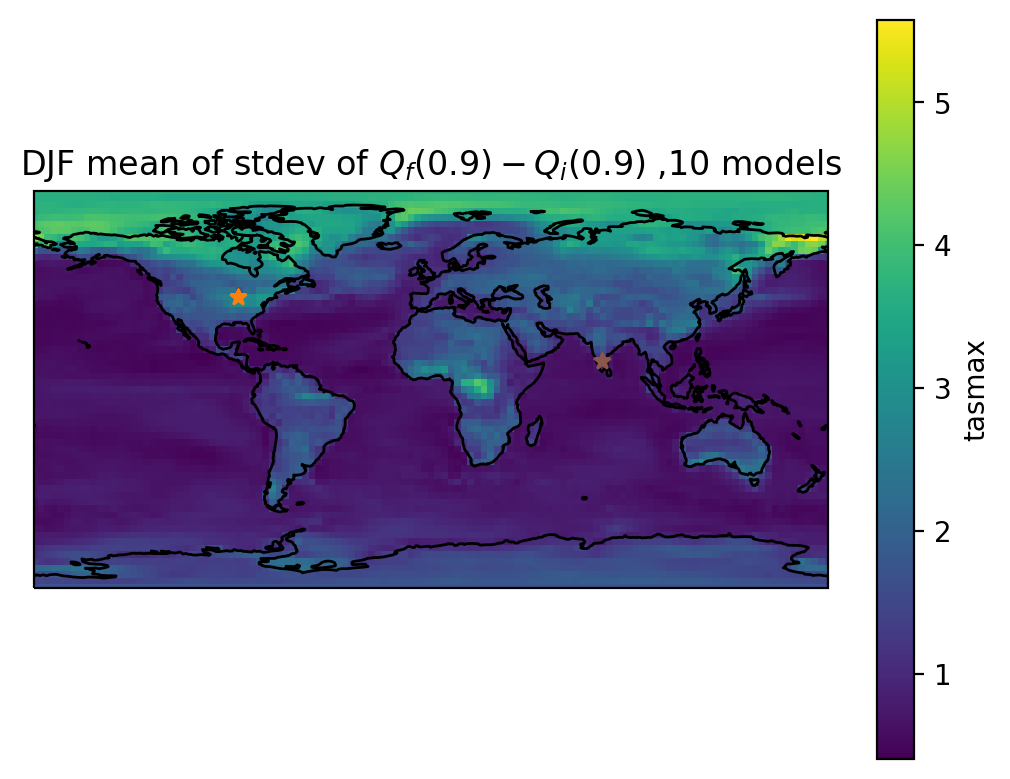

In [36]:
#Check
ax            = plt.axes(projection=cart.crs.PlateCarree())
qano_djf_std_mean.sel(quantile=0.9,method='nearest').plot(ax=ax,transform=cart.crs.PlateCarree())
                                         #cbar_kwargs={'ticks':ticks})
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
plt.title(r'DJF mean of stdev of $Q_f(0.9) -Q_i(0.9)$ ,10 models')
plt.show()

In [37]:
#Check
qano_djf_std         = qcmip6_djf_ano.std('source_id')
qano_djf_std_sgmean  = global_mean(qano_djf_std)
qano_djf_std_sgmean.values

array([1.66130754, 1.39358208, 1.28714619, 1.22682645, 1.18830142,
       1.16103371, 1.13826528, 1.12062802, 1.10732657, 1.09657648,
       1.08775027, 1.07881424, 1.07191309, 1.06712115, 1.06368677,
       1.06095218, 1.05856579, 1.05734194, 1.05757638, 1.0593436 ,
       1.06155647, 1.06511394, 1.07052953, 1.07932037, 1.09236877,
       1.10836569, 1.13229586, 1.17134524, 1.24460363, 1.42218856])

In [48]:
qcmip6  = xr.concat([qcmip6_djf,qcmip6_mam,qcmip6_jja,qcmip6_son],dim='day')
qcmip6 

<xarray.DataArray 'tasmax' (source_id: 10, experiment_id: 2, quantile: 30,
                            day: 370, lat: 61, lon: 121)>
dask.array<concatenate, shape=(10, 2, 30, 370, 61, 121), dtype=float64, chunksize=(3, 1, 8, 24, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * day            (day) int64 1 2 3 4 5 6 7 8 ... 329 330 331 332 333 334 335
  * experiment_id  (experiment_id) <U10 'ssp370' 'historical'
  * lat            (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 75 78 81 84 87 90
  * lon            (lon) int64 0 3 6 9 12 15 18 ... 342 345 348 351 354 357 360
  * quantile       (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * source_id      (source_id) <U17 'ACCESS-CM2' ... 'MRI-ESM2-0'

In [49]:
qano     =  qcmip6.sel(experiment_id='ssp370') - qcmip6.sel(experiment_id='historical')
qano_std = qano.std(dim='source_id')
qano_std

<xarray.DataArray 'tasmax' (quantile: 30, day: 370, lat: 61, lon: 121)>
dask.array<_sqrt, shape=(30, 370, 61, 121), dtype=float64, chunksize=(8, 24, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 328 329 330 331 332 333 334 335
  * lat       (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon       (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [ ]:
qano_std

In [ ]:
#sgmean = seasonal, global mean
qano_std_sgmean = global_mean(qano_std)

(0.0, 1.0)

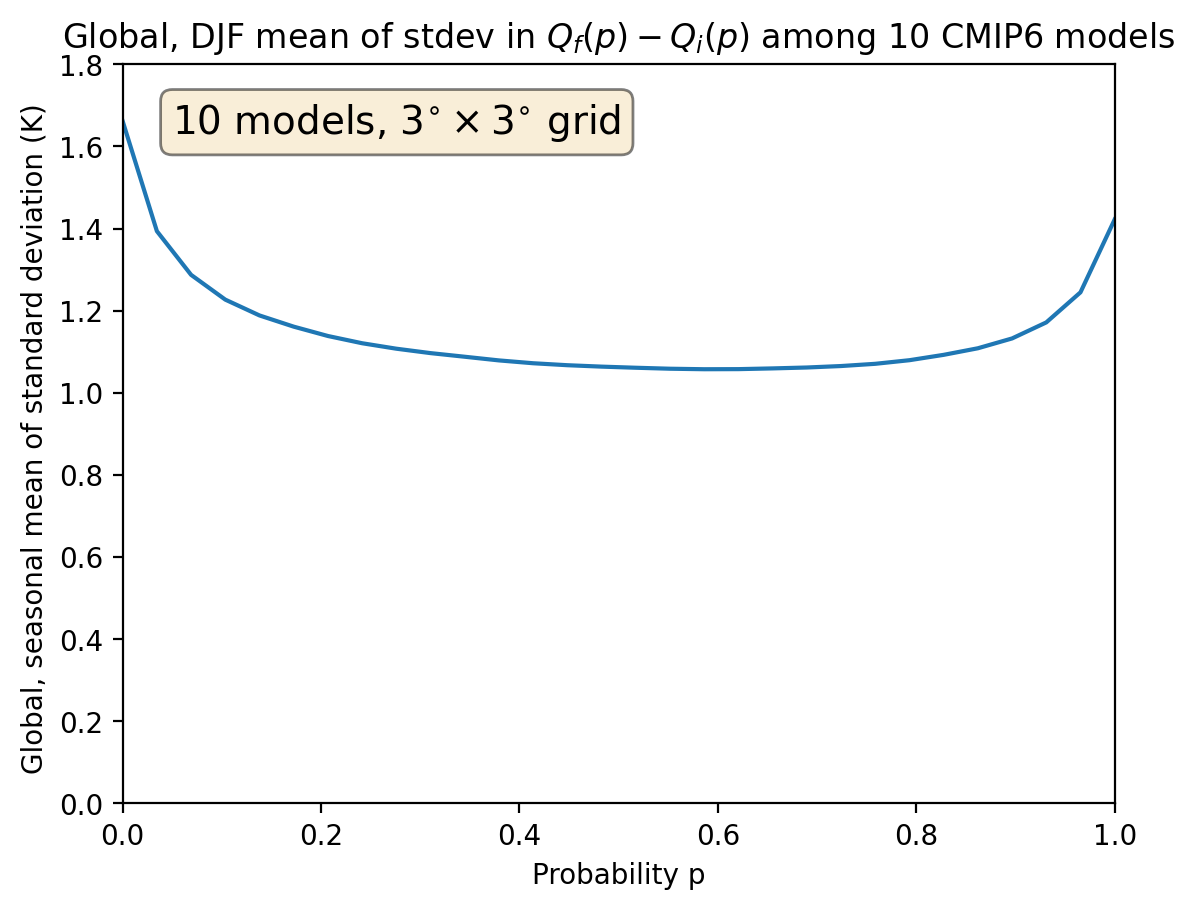

In [20]:
quant_ano_std_sgmean.plot()
plt.xlabel('Probability p')
plt.ylabel('Global, annual mean of standard deviation (K) ')
plt.title(r'Global, annual mean of stdev in $Q_f(p) -Q_i(p)$ among 10 CMIP6 models')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'10 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.ylim(0,1.8)
plt.xlim(0,1.0)

In [ ]:
################################################################